In [1]:
import os
import numpy as np
import pandas as pd
import pyswarm
import scipy.stats as sps

import argus_shapes
import pulse2percept.implants as p2pi
from pulse2percept.retina import ret2dva, dva2ret

import sklearn.base as sklb
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-talk')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-04-29 00:18:14,222 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
subject_params = {
    'TB': {
        'implant_type': p2pi.ArgusI,
        'implant_x': -1527,
        'implant_y': -556,
        'implant_rot': -1.13,
        'loc_od_x': 13.6,
        'loc_od_y': 0.0,
        'xrange': (-36.9, 36.9),
        'yrange': (-36.9, 36.9)
    },
    '12-005': {
        'implant_type': p2pi.ArgusII,
        'implant_x': -1761,
        'implant_y': -212,
        'implant_rot': -0.188,
        'loc_od_x': 15.4,
        'loc_od_y': 1.86,
        'xrange': (-30, 30),
        'yrange': (-22.5, 22.5)
    },
    '51-009': {
        'implant_type': p2pi.ArgusII,
        'implant_x': -799,
        'implant_y': 93,
        'implant_rot': -1.09,
        'loc_od_x': 15.7,
        'loc_od_y': 0.75,
        'xrange': (-32.5, 32.5),
        'yrange': (-24.4, 24.4)
    },
    '52-001': {
        'implant_type': p2pi.ArgusII,
        'implant_x': -1230,
        'implant_y': 415,
        'implant_rot': -0.457,
        'loc_od_x': 15.9,
        'loc_od_y': 1.96,
        'xrange': (-32, 32),
        'yrange': (-24, 24)
    }
}

use_electrodes = {
    'TB': ['A4', 'C2', 'C3', 'C4', 'D2', 'D3', 'B3', 'D4'],
    '12-005': ['A04', 'A06', 'B03', 'C07', 'C10', 'D07', 'D08', 'D10',
               'F06'],
    '51-009': ['A02', 'C01', 'C05', 'C06', 'D03', 'E01', 'E05', 'E07',
               'F04', 'F06'],
    '52-001': ['A05', 'A07', 'B09', 'A10', 'C10', 'D05', 'D07', 'E04',
               'E09', 'E10', 'F06', 'F07', 'F08', 'F09', 'F10']
}

In [3]:
subjects = ['TB', '12-005', '51-009', '52-001']

In [4]:
y_trial = {}
y_grouped = {}
y_mean = {}
for subject in subjects:
    implant_setup = subject_params[subject]
    X, y = argus_shapes.load_data(os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape', subject), 
                                amplitude=2.0)
    y.loc[:, 'electrode'] = ['%s%d' % (row['electrode'][0], int(row['electrode'][1:])) for _, row in y.iterrows()]
    y_trial[subject] = y
    y_grouped[subject] = y.groupby('electrode', as_index=False).agg(['mean', 'std'])
    _, y = argus_shapes.calc_mean_images(X, y, max_area=5)
    y_mean[subject] = y

In [5]:
import pulse2percept as p2p
from matplotlib import patches
def plot_orientation(subject, y_grouped):
    implant_setup = subject_params[subject]
    implant = implant_setup['implant_type'](x_center=implant_setup['implant_x'], 
                                            y_center=implant_setup['implant_y'],
                                            rot=implant_setup['implant_rot'])
    sim = p2p.Simulation(implant)
    sim.set_optic_fiber_layer(sampling=500, n_rho=71, n_axons=301, x_range=(0, 0), y_range=(0, 0),
                              loc_od=(implant_setup['loc_od_x'], implant_setup['loc_od_y']))
    sim.plot_fundus(ax=ax, annotate=True, upside_down=True)
    if isinstance(implant, p2p.implants.ArgusII):
        patch = patches.Rectangle((implant['A1'].x_center-400, implant['A1'].y_center-200),
                                  525*9+800, 525*5+800, color='gray', alpha=0.5,
                                  angle=np.rad2deg(implant_setup['implant_rot']), zorder=10)
    else:
        patch = patches.Rectangle((implant['A1'].x_center-700, implant['A1'].y_center+300),
                                  900*4, 900*4, color='gray', alpha=0.5,
                                  angle=np.rad2deg(implant_setup['implant_rot']), zorder=10)
    ax.add_patch(patch)
    for electrode, row in y_grouped.iterrows():
        theta = row['orientation']['mean']
        ax.quiver(implant[electrode].x_center, implant[electrode].y_center,
                  np.cos(theta), np.sin(theta), color='w', zorder=100)
    ax.set_title(subject)


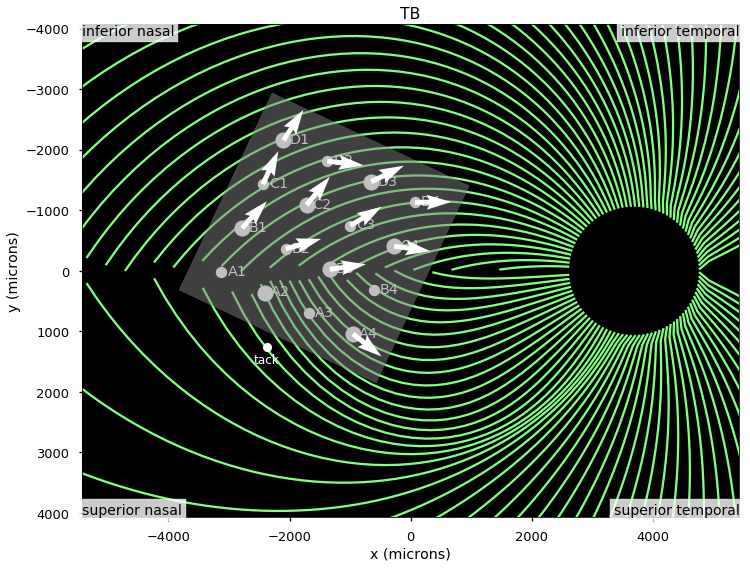

In [6]:
subject = 'TB'
fig, ax = plt.subplots(figsize=(12, 8), squeeze=True)
plot_orientation(subject, y_grouped[subject])
fig.tight_layout()
fig.savefig('TB-axons.eps')

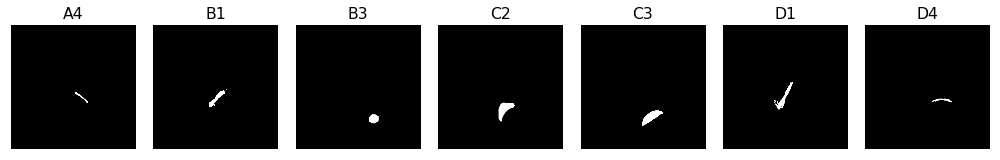

In [7]:
els = ['A4', 'B1', 'B3', 'C2', 'C3', 'D1', 'D4']
yy = y_mean[subject]
fig, axes = plt.subplots(ncols=len(els), figsize=(14, 4))
for el, ax in zip(els, axes):
    row = yy[yy['electrode'] == el].reset_index()
    if row.empty:
        continue
    img = row.image[0]
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(el)
fig.tight_layout()
fig.savefig('TB-axons-drawings.eps')

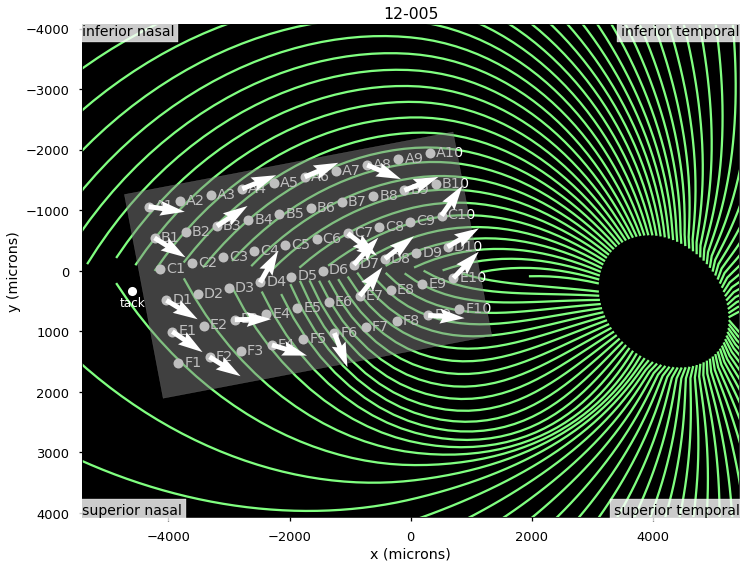

In [8]:
subject = '12-005'
fig, ax = plt.subplots(figsize=(12, 8), squeeze=True)
plot_orientation(subject, y_grouped[subject])
fig.tight_layout()
fig.savefig('12-005-axons.eps')

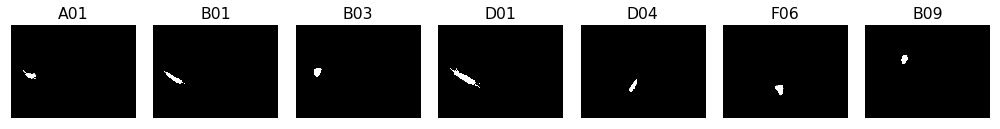

In [9]:
els = ['A01', 'B01', 'B03', 'D01', 'D04', 'F06', 'B09']
yy = y_mean[subject]
fig, axes = plt.subplots(ncols=len(els), figsize=(14, 4))
for el, ax in zip(els, axes):
    row = yy[yy['electrode'] == el].reset_index()
    if row.empty:
        continue
    img = row.image[0]
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(el)
fig.tight_layout()
fig.savefig('12-005-axons-drawings.eps')

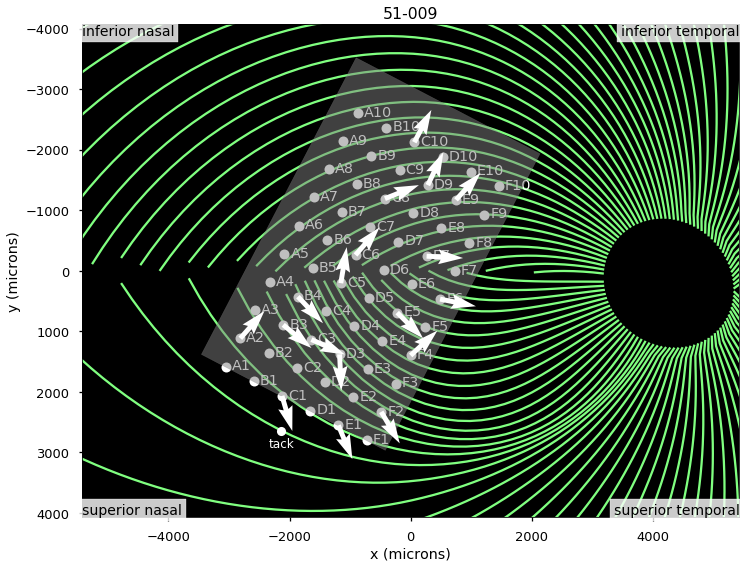

In [10]:
subject = '51-009'
fig, ax = plt.subplots(figsize=(12, 8), squeeze=True)
plot_orientation(subject, y_grouped[subject])
fig.tight_layout()
fig.savefig('51-009-axons.eps')

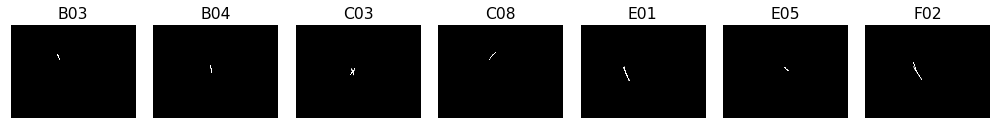

In [11]:
els = ['B03', 'B04', 'C03', 'C08', 'E01', 'E05', 'F02']
yy = y_mean[subject]
fig, axes = plt.subplots(ncols=len(els), figsize=(14, 4))
for el, ax in zip(els, axes):
    row = yy[yy['electrode'] == el].reset_index()
    if row.empty:
        continue
    img = row.image[0]
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(el)
fig.tight_layout()
fig.savefig('51-009-axons-drawings.eps')

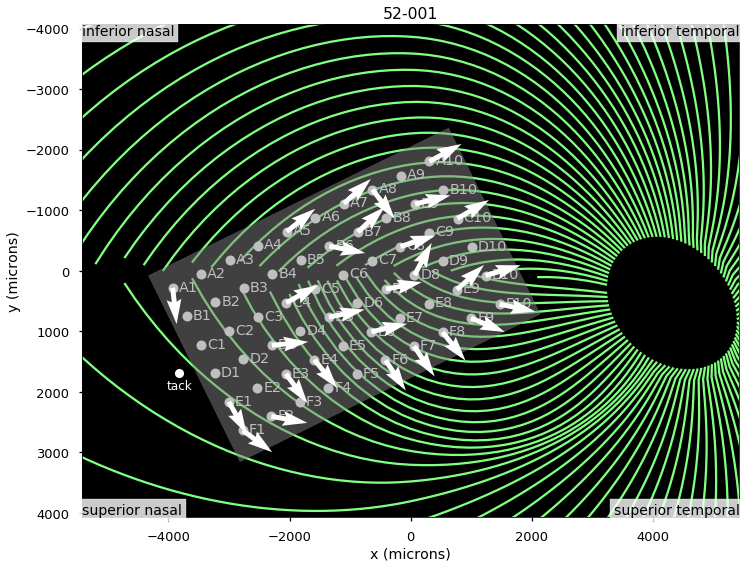

In [12]:
subject = '52-001'
fig, ax = plt.subplots(figsize=(12, 8), squeeze=True)
plot_orientation(subject, y_grouped[subject])
fig.tight_layout()
fig.savefig('52-001-axons.eps')

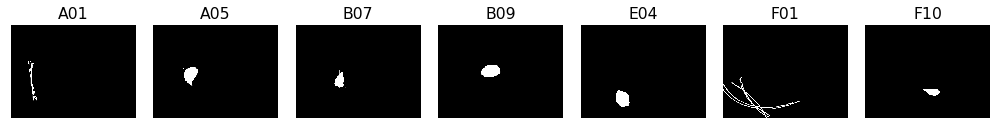

In [13]:
els = ['A01', 'A05', 'B07', 'B09', 'E04', 'F01', 'F10']
yy = y_mean[subject]
fig, axes = plt.subplots(ncols=len(els), figsize=(14, 4))
for el, ax in zip(els, axes):
    row = yy[yy['electrode'] == el].reset_index()
    if row.empty:
        continue
    img = row.image[0]
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(el)
fig.tight_layout()
fig.savefig('52-001-axons-drawings.eps')